Authors: Antonio Miranda Escalada

# 0. SOME PRELIMINARIES 

In [1]:
# Import some libraries
import matplotlib.pyplot as plt 
# For plotting data
import numpy as np              
# For Panda dataframes. A dataframe is a matrix-like structure, 
# similar to R dataframes  
import pandas as pd

from sklearn import metrics, neighbors, tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from catboost import Pool, CatBoostRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlxtend
from kneed import KneeLocator


import os
os.getcwd()

C:\Users\toni3\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


'C:\\Users\\toni3\\Documents\\Universidad\\Master\\2\\BD Intelligence methods and technologies\\Assignments\\3'

The "wind_pickle" file contains data in a binary format called "Pickle". Pickle data loads faster than text data.

In [2]:
data = pd.read_pickle('wind_pickle.pickle')

You can visualize the attributes in the dataset. Very important, the output attribute (i.e. the value to be predicted, **energy**, is the first attribute). **Steps** represents the hours in advance of the forecast. We will not use this variable here.

In [3]:
# The dataset contains 5937 instances and 556 attributes (including 
# the outcome to be predicted)
print(data.shape)
#data.columns.values.tolist()

(5937, 556)


Below, data is going to be separated in train, validation, and test. Given that the use of Pandas dataframes is quite advanced, I am doing this for you:

In [4]:
indicesTrain = (np.where(data.year<=2006))[0]
indicesVal = (np.where((data.year==2007) | (data.year==2008)))[0]
indicesTest = (np.where(data.year>=2009))[0]

Beware!, **indicesTrain** does not contain the training data, but the *indices* of the training data. For instance, the following cell means that training data is made of instance number 0, instance number 1, ..., up to instance number 2527. This will be important later.

In [5]:
indicesTrain

array([   0,    1,    2, ..., 2525, 2526, 2527], dtype=int64)

Now, we are going to transform **data**, which is a Pandas dataframe, to **ava**, which is a NumPy matrix. The reason is that Scikit-learn uses NumPy matrices, not Panda dataframes.

In [6]:
ava = data.values

Now, **ava** is going to be decomposed into inputs **X** and outputs **y**. And then, into training, validation, and test. For instance, **Xava** and **yava** contain the input attributes, and the output attribute (**energy**) of the whole dataset. Please, ask yourself why the inputs use "6:" and the output use "0". **Xtrain** and **ytrain** are the same, but for the training dataset.

In [7]:
Xava = ava[:,6:]; yava = ava[:,0]
Xtrain = ava[indicesTrain,6:]; ytrain = ava[indicesTrain,0]
Xval = ava[indicesVal,6:]; yval = ava[indicesVal,0]
Xtest = ava[indicesTest,6:]; ytest = ava[indicesTest,0]

In [8]:
# We create a dataset with train and validation data
indicesTrainAndVal = (np.where(data.year<=2008))[0]
XtrainAndVal = ava[indicesTrainAndVal,6:]; ytrainAndVal = ava[indicesTrainAndVal,0]

The following cell defines function **mae** (Mean Absolute Error), that we will use later to measure the accuracy of models.

In [9]:
def mae(yval_pred, yval):
  val_mae = metrics.mean_absolute_error(yval_pred, yval)
  return(val_mae)

The following cell trains KNN with (Xtrain, ytrain) and evaluates it with (Xval, yval).

In [8]:
np.random.seed(0)

n_neighbors = 5
knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
%time _ = knn.fit(Xtrain, ytrain)
yval_pred = knn.predict(Xval)

print("MAE for KNN with K=5 is {}".format(mae(yval_pred, yval)))

Wall time: 151 ms
MAE for KNN with K=5 is 486.91141493456513


In [10]:
# In case you need help for KNN
help('sklearn.neighbors.KNeighborsRegressor')

Help on class KNeighborsRegressor in sklearn.neighbors:

sklearn.neighbors.KNeighborsRegressor = class KNeighborsRegressor(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedFloatMixin, sklearn.base.RegressorMixin)
 |  sklearn.neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1, **kwargs)
 |  
 |  Regression based on k-nearest neighbors.
 |  
 |  The target is predicted by local interpolation of the targets
 |  associated of the nearest neighbors in the training set.
 |  
 |  Read more in the :ref:`User Guide <regression>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points 

The following cell, does hyper-parameter tuning for parameter K (n_neighbors), from 1 to 4 by 1. Please, notice that with **partitions = [(indicesTrain, indicesVal)]** we are telling **gridSearch** to use the training dataset for training the different models with the different parameters, and the validation dataset for testing. Notice that this is different to other notebooks, where crossvalidation was used for this purpose. 

In [9]:
np.random.seed(0)

param_grid = {'n_neighbors': list(range(1,4,1))}

partitions = [(indicesTrain, indicesVal)]

clf = GridSearchCV(neighbors.KNeighborsRegressor(), 
                   param_grid,
                   scoring='neg_mean_absolute_error',
                   cv=partitions , verbose=0)
%time _ = clf.fit(Xava,yava)

Wall time: 4.21 s


Next, we show the best K parameter and the MAE of the final model built with the best parameter.

In [10]:
print("Best K: {} and MAE for best K: {}".format(clf.best_params_, -clf.best_score_))

Best K: {'n_neighbors': 3} and MAE for best K: 503.71169104439315


# 1. HOW LONG DOES IT TAKE?

It is always a good idea to have some estimation of how long your machine learning algorithm is going to take. In the next two cells, try to estimate how many seconds KNN (with K=3) does it take, with only **100 instances**. With 6000 instances, it will take approximately 60 times that number. You can use **%time** for timing, as in previous cells.

In [11]:
np.random.seed(0)

n_neighbors = 3
knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
%time _ = knn.fit(Xtrain[0:100,], ytrain[0:100])

Wall time: 2.01 ms


Please, do the same for Decision trees with default parameters

In [12]:
np.random.seed(0)

method_tree = tree.DecisionTreeRegressor()
%time _ = method_tree.fit(Xtrain[0:100,], ytrain[0:100])

Wall time: 29.1 ms


# 2. MODEL SELECTION AND HYPER-PARAMETER TUNING

Train a KNN model with default hiper-parameters

In [13]:
np.random.seed(0)

knn = neighbors.KNeighborsRegressor()
model_knn = knn.fit(Xtrain, ytrain)
knn_pred = model_knn.predict(Xval)
print("MAE for KNN default is {}".format(mae(knn_pred, yval)))

MAE for KNN default is 486.91141493456513


Do hyper-parameter tuning for KNN. Can you improve results? Note: I will specially value if you use model based optimization (**skopt**). If not possible, use **Randomized Search** instead.

In [14]:
# Hyper-parameter tuning --> Bayesian Optimization
np.random.seed(0)

param_knn_bayes_grid = {'n_neighbors': (1,20)}
budget = 10
method_knn_bayes = BayesSearchCV(
        neighbors.KNeighborsRegressor(), 
        param_knn_bayes_grid, 
        scoring='neg_mean_absolute_error',
        refit = False,
        cv = partitions, 
        n_jobs =1, 
        verbose = 0,
        n_iter = budget
)

model_knn_bayes = method_knn_bayes.fit(Xava, yava)
print("Best Bayes search K: {} and MAE for best K: {}".format(model_knn_bayes.best_params_, 
                                                              -model_knn_bayes.best_score_))

Best Bayes search K: {'n_neighbors': 17} and MAE for best K: 469.78749943395366


In [15]:
#The final knn model is going to be trained with train and validation
#datasets in order to obtain the final performance over the test partition
np.random.seed(0)

knn_final = neighbors.KNeighborsRegressor()
knn_final.set_params(**model_knn_bayes.best_params_)
model_knn_final = knn_final.fit(XtrainAndVal, ytrainAndVal)
model_knn_final_test_pred = model_knn_final.predict(Xtest)
print("MAE for KNN final is {}".format(mae(model_knn_final_test_pred, ytest)))

MAE for KNN final is 511.40569863395604


Train a decision tree for regression with default hiper-parameters

In [17]:
np.random.seed(0)

method_tree = tree.DecisionTreeRegressor()
model_tree = method_tree.fit(Xtrain, ytrain)
tree_pred = model_tree.predict(Xval)
print("MAE for DecisionTree default is {}".format(mae(tree_pred, yval)))

MAE for DecisionTree default is 371.82943033102384


Do hyper-parameter tuning for Decision trees. Can you improve results?

In [17]:
# Hyper-parameter tuning --> Bayesian Optimization
np.random.seed(0)

#In spite of the different hyper-parameters for a decision tree (max_depth, min_samples_split, max_features, min_samples_leaf),
#only max_depth and min_samples_split are used because of the academic goal of this study
param_tree_bayes_grid = {'max_depth': (2,30),
                         'min_samples_split': (2,100)
}
budget = 40
method_tree_bayes = BayesSearchCV(
        tree.DecisionTreeRegressor(), 
        param_tree_bayes_grid, 
        scoring='neg_mean_absolute_error',
        refit = False,
        cv = partitions, 
        n_jobs =1, 
        verbose = 0,
        n_iter = budget
)

model_tree_bayes = method_tree_bayes.fit(Xava, yava)
print("Best Bayes search max_depth, min_samples_split: {} \
and MAE for best Decision tree: {}".format(model_tree_bayes.best_params_, -model_tree_bayes.best_score_))

tree_final = tree.DecisionTreeRegressor()
tree_final.set_params(**model_tree_bayes.best_params_)
model_tree_final = tree_final.fit(XtrainAndVal, ytrainAndVal)
model_tree_final_test_pred = model_tree_final.predict(Xtest)
print("MAE for Decision Tree final is {}".format(mae(model_tree_final_test_pred, ytest)))


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Bayes search max_depth, min_samples_split: {'max_depth': 6, 'min_samples_split': 81} and MAE for best Decision tree: 303.7726118568905
MAE for Decision Tree final is 310.9637342803766


Train a Random Forest (RF) with default parameters. A RF is an ensemble technique based on Decision Trees, but instead of training just a single decision tree, it trains many of them and then computes the average of the outputs. Please, bear in mind that a RF with default parameters involves training 100 trees. You can estimate by hand how long it is going to take, and if it is excessive, you can lower the number of decision trees in the ensemble. 

In [19]:
np.random.seed(0)

rf = RandomForestRegressor()
model_rf = rf.fit(Xtrain, ytrain)
rf_pred = model_rf.predict(Xval)
print("MAE for Random Forest default is {}".format(mae(rf_pred, yval)))

MAE for Random Forest default is 287.27191993841416


Do hyper-parameter tuning for Random Forests. Their main hyper-parameter is **n_estimators**, which is the number of decision trees in the ensemble. Check some values around the default value (like, 50, 100, 150, ...). Please, bear in mind this is going to take time ... In case you want to use other hyper-parameters, please ask the teacher.

In [26]:
# Hyper-parameter tuning --> Bayesian Optimization
np.random.seed(0)

param_rf_bayes_grid = {'n_estimators': (5,200)
}
budget = 40
rf_bayes = BayesSearchCV(
        RandomForestRegressor(), 
        param_rf_bayes_grid, 
        scoring='neg_mean_absolute_error',
        refit = False,
        cv = partitions, 
        n_jobs =1, 
        verbose = 0,
        n_iter = budget
)

model_rf_bayes = rf_bayes.fit(Xava, yava)
print("Best Bayes search n_estimator: {} and MAE for best Random Forest: {}".format(model_rf_bayes.best_params_,
                                                                                    -model_rf_bayes.best_score_))

rf_final = RandomForestRegressor()
rf_final.set_params(**model_rf_bayes.best_params_)
model_rf_final = rf_final.fit(XtrainAndVal, ytrainAndVal)
model_rf_final_test_pred = model_rf_final.predict(Xtest)
print("MAE for Random Forest final is {}".format(mae(model_rf_final_test_pred, ytest)))

C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\

Best Bayes search n_estimator: {'n_estimators': 200} and MAE for best Random Forest: 274.8996147806004
MAE for Random Forest final is 283.42557500000004


Train a Gradient Tree Boosting (GB) with default parameters. A GB is also an ensemble technique based on Decision Trees. In this case, the second decision tree tries to fix the mistakes of the first decision tree. The third decision tree tries to fix the mistakes of the first two decision trees. An so on.

Please, bear in mind that a GB with default parameters involves training 100 trees. You can estimate by hand how long it is going to take, and if it is excessive, you can lower the number of decision trees in the ensemble. 

In [21]:
np.random.seed(0)

gb = GradientBoostingRegressor()
model_gb = gb.fit(Xtrain, ytrain)
gb_pred = model_gb.predict(Xval)
print("MAE for Gradient Boosting default is {}".format(mae(gb_pred, yval)))

MAE for Gradient Boosting default is 280.82732452932765


Do hyper-parameter tuning for Gradient Boosting. Their main hyper-parameter is **n_estimators**, which is the number of decision trees in the ensemble. Check some values around the default value (like, 50, 100, 150, ...). Please, bear in mind this is going to take time ... In case you want to use other hyper-parameters, please ask the teacher.

In [27]:
np.random.seed(0)
param_gb_bayes_grid = {'n_estimators': (50,200)
}
budget = 40
method_gb_bayes = BayesSearchCV(
        GradientBoostingRegressor(), 
        param_gb_bayes_grid, 
        scoring='neg_mean_absolute_error',
        refit = False,
        cv = partitions, 
        n_jobs =1, 
        verbose = 0,
        n_iter = budget
)

model_gb_bayes = method_gb_bayes.fit(Xava, yava)
print("Best Bayes search n_estimator: {} and MAE for best Gradient Boosting: {}".format(model_gb_bayes.best_params_,
                                                                                        -model_gb_bayes.best_score_))

gb_final = GradientBoostingRegressor()
gb_final.set_params(**model_gb_bayes.best_params_)
model_gb_final = gb_final.fit(XtrainAndVal, ytrainAndVal)
model_gb_final_test_pred = model_gb_final.predict(Xtest)
print("MAE for Gradient Boosting final is {}".format(mae(model_gb_final_test_pred, ytest)))

C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\

Best Bayes search n_estimator: {'n_estimators': 133} and MAE for best Gradient Boosting: 278.5243999140768
MAE for Gradient Boosting final is 289.59716170662733


We will try now with a more powerful implementation of GB: CatBoost (this implementation is specific for categorical data, but the library XGBoost did not work properly on our personal laptops, and CatBoost also performs well on numeric data). Due to the computational time of CatBoost we had to use a very low number of estimators. Then, the final performance is poor. However, we know it is powerful and should compete with Random Forest and the scikit implementation of Gradient Boosting Machine.

In [12]:
model = CatBoostRegressor(iterations=10)
model.fit(Xtrain, ytrain)
preds = model.predict(Xval)
print("MAE forXGBoost default is {}".format(mae(preds, yval)))

0:	learn: 926.2647360	total: 772ms	remaining: 6.95s
1:	learn: 906.3758016	total: 1.23s	remaining: 4.9s
2:	learn: 886.3932667	total: 1.65s	remaining: 3.85s
3:	learn: 867.4944761	total: 2.1s	remaining: 3.15s
4:	learn: 848.7492804	total: 2.52s	remaining: 2.52s
5:	learn: 830.6348224	total: 2.97s	remaining: 1.98s
6:	learn: 813.3819569	total: 3.39s	remaining: 1.45s
7:	learn: 796.6452840	total: 3.83s	remaining: 958ms
8:	learn: 780.2373449	total: 4.28s	remaining: 475ms
9:	learn: 764.5699727	total: 4.73s	remaining: 0us
MAE forXGBoost default is 563.3728300381824


In [13]:
# Hyper-parameter tuning
np.random.seed(0)

cat = CatBoostRegressor()
param_grid_cat = {'n_estimators': (1, 10)}
partitions = [(indicesTrain, indicesVal)]
budget = 40

bayes_cat = BayesSearchCV(
        cat,
        param_grid_cat,
        scoring='neg_mean_absolute_error', 
        refit = False,
        cv=partitions,
        n_jobs=1, 
        verbose=0, 
        n_iter=budget
)

model_cat = bayes_cat.fit(Xava, yava)
print("Best hyper-parameters: {} and MAE for best hyper-parameters: {}".format(model_cat.best_params_,
                                                                               -model_cat.best_score_))

#### final model 
cat_final = CatBoostRegressor()
cat_final.set_params(**model_cat.best_params_)
model_cat_final = cat_final.fit(XtrainAndVal, ytrainAndVal)
model_cat_final_test_pred = model_cat_final.predict(Xtest)
print("MAE for CatBoost final is {}".format(mae(model_cat_final_test_pred, ytest)))

0:	learn: 926.2647360	total: 595ms	remaining: 2.97s
1:	learn: 906.3758016	total: 1.03s	remaining: 2.07s
2:	learn: 886.3932667	total: 1.47s	remaining: 1.47s
3:	learn: 867.4944761	total: 1.91s	remaining: 957ms
4:	learn: 848.7492804	total: 2.35s	remaining: 469ms
5:	learn: 830.6348224	total: 2.79s	remaining: 0us
0:	learn: 926.2647360	total: 560ms	remaining: 1.12s
1:	learn: 906.3758016	total: 996ms	remaining: 498ms
2:	learn: 886.3932667	total: 1.41s	remaining: 0us
0:	learn: 926.2647360	total: 573ms	remaining: 2.87s
1:	learn: 906.3758016	total: 998ms	remaining: 2s
2:	learn: 886.3932667	total: 1.42s	remaining: 1.42s
3:	learn: 867.4944761	total: 1.86s	remaining: 929ms
4:	learn: 848.7492804	total: 2.28s	remaining: 455ms
5:	learn: 830.6348224	total: 2.76s	remaining: 0us
0:	learn: 926.2647360	total: 570ms	remaining: 570ms
1:	learn: 906.3758016	total: 1s	remaining: 0us
0:	learn: 926.2647360	total: 608ms	remaining: 1.22s
1:	learn: 906.3758016	total: 1.05s	remaining: 524ms
2:	learn: 886.3932667	tota

C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 579ms	remaining: 5.21s
1:	learn: 906.3758016	total: 1.01s	remaining: 4.05s
2:	learn: 886.3932667	total: 1.44s	remaining: 3.36s
3:	learn: 867.4944761	total: 1.88s	remaining: 2.82s
4:	learn: 848.7492804	total: 2.3s	remaining: 2.3s
5:	learn: 830.6348224	total: 2.8s	remaining: 1.87s
6:	learn: 813.3819569	total: 3.23s	remaining: 1.38s
7:	learn: 796.6452840	total: 3.68s	remaining: 919ms
8:	learn: 780.2373449	total: 4.1s	remaining: 455ms
9:	learn: 764.5699727	total: 4.59s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 605ms	remaining: 5.45s
1:	learn: 906.3758016	total: 1.1s	remaining: 4.4s
2:	learn: 886.3932667	total: 1.63s	remaining: 3.79s
3:	learn: 867.4944761	total: 2.13s	remaining: 3.19s
4:	learn: 848.7492804	total: 2.62s	remaining: 2.62s
5:	learn: 830.6348224	total: 3.13s	remaining: 2.09s
6:	learn: 813.3819569	total: 3.57s	remaining: 1.53s
7:	learn: 796.6452840	total: 4.03s	remaining: 1.01s
8:	learn: 780.2373449	total: 4.43s	remaining: 492ms
9:	learn: 764.5699727	total: 4.86s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 558ms	remaining: 5.02s
1:	learn: 906.3758016	total: 988ms	remaining: 3.95s
2:	learn: 886.3932667	total: 1.45s	remaining: 3.38s
3:	learn: 867.4944761	total: 1.95s	remaining: 2.92s
4:	learn: 848.7492804	total: 2.42s	remaining: 2.42s
5:	learn: 830.6348224	total: 2.9s	remaining: 1.94s
6:	learn: 813.3819569	total: 3.39s	remaining: 1.45s
7:	learn: 796.6452840	total: 3.88s	remaining: 971ms
8:	learn: 780.2373449	total: 4.32s	remaining: 480ms
9:	learn: 764.5699727	total: 4.77s	remaining: 0us
0:	learn: 926.2647360	total: 561ms	remaining: 3.93s
1:	learn: 906.3758016	total: 999ms	remaining: 3s
2:	learn: 886.3932667	total: 1.44s	remaining: 2.39s
3:	learn: 867.4944761	total: 1.9s	remaining: 1.9s
4:	learn: 848.7492804	total: 2.34s	remaining: 1.4s
5:	learn: 830.6348224	total: 2.8s	remaining: 933ms
6:	learn: 813.3819569	total: 3.23s	remaining: 461ms
7:	learn: 796.6452840	total: 3.68s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 548ms	remaining: 4.93s
1:	learn: 906.3758016	total: 969ms	remaining: 3.87s
2:	learn: 886.3932667	total: 1.39s	remaining: 3.24s
3:	learn: 867.4944761	total: 1.87s	remaining: 2.81s
4:	learn: 848.7492804	total: 2.31s	remaining: 2.31s
5:	learn: 830.6348224	total: 2.8s	remaining: 1.86s
6:	learn: 813.3819569	total: 3.22s	remaining: 1.38s
7:	learn: 796.6452840	total: 3.65s	remaining: 914ms
8:	learn: 780.2373449	total: 4.07s	remaining: 452ms
9:	learn: 764.5699727	total: 4.5s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 606ms	remaining: 5.46s
1:	learn: 906.3758016	total: 1.07s	remaining: 4.28s
2:	learn: 886.3932667	total: 1.54s	remaining: 3.59s
3:	learn: 867.4944761	total: 2.01s	remaining: 3.02s
4:	learn: 848.7492804	total: 2.44s	remaining: 2.44s
5:	learn: 830.6348224	total: 2.91s	remaining: 1.94s
6:	learn: 813.3819569	total: 3.34s	remaining: 1.43s
7:	learn: 796.6452840	total: 3.78s	remaining: 944ms
8:	learn: 780.2373449	total: 4.19s	remaining: 465ms
9:	learn: 764.5699727	total: 4.62s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 609ms	remaining: 5.48s
1:	learn: 906.3758016	total: 1.05s	remaining: 4.21s
2:	learn: 886.3932667	total: 1.49s	remaining: 3.47s
3:	learn: 867.4944761	total: 1.92s	remaining: 2.88s
4:	learn: 848.7492804	total: 2.34s	remaining: 2.34s
5:	learn: 830.6348224	total: 2.78s	remaining: 1.85s
6:	learn: 813.3819569	total: 3.23s	remaining: 1.38s
7:	learn: 796.6452840	total: 3.71s	remaining: 928ms
8:	learn: 780.2373449	total: 4.18s	remaining: 465ms
9:	learn: 764.5699727	total: 4.63s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 591ms	remaining: 5.32s
1:	learn: 906.3758016	total: 1.05s	remaining: 4.21s
2:	learn: 886.3932667	total: 1.53s	remaining: 3.57s
3:	learn: 867.4944761	total: 2.01s	remaining: 3.02s
4:	learn: 848.7492804	total: 2.48s	remaining: 2.48s
5:	learn: 830.6348224	total: 2.94s	remaining: 1.96s
6:	learn: 813.3819569	total: 3.39s	remaining: 1.45s
7:	learn: 796.6452840	total: 3.84s	remaining: 961ms
8:	learn: 780.2373449	total: 4.26s	remaining: 473ms
9:	learn: 764.5699727	total: 4.71s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 547ms	remaining: 4.92s
1:	learn: 906.3758016	total: 966ms	remaining: 3.87s
2:	learn: 886.3932667	total: 1.39s	remaining: 3.23s
3:	learn: 867.4944761	total: 1.88s	remaining: 2.83s
4:	learn: 848.7492804	total: 2.3s	remaining: 2.3s
5:	learn: 830.6348224	total: 2.73s	remaining: 1.82s
6:	learn: 813.3819569	total: 3.16s	remaining: 1.35s
7:	learn: 796.6452840	total: 3.59s	remaining: 899ms
8:	learn: 780.2373449	total: 4.01s	remaining: 445ms
9:	learn: 764.5699727	total: 4.44s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 615ms	remaining: 5.54s
1:	learn: 906.3758016	total: 1.09s	remaining: 4.34s
2:	learn: 886.3932667	total: 1.51s	remaining: 3.53s
3:	learn: 867.4944761	total: 1.97s	remaining: 2.95s
4:	learn: 848.7492804	total: 2.39s	remaining: 2.39s
5:	learn: 830.6348224	total: 2.88s	remaining: 1.92s
6:	learn: 813.3819569	total: 3.38s	remaining: 1.45s
7:	learn: 796.6452840	total: 3.9s	remaining: 974ms
8:	learn: 780.2373449	total: 4.36s	remaining: 484ms
9:	learn: 764.5699727	total: 4.84s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 559ms	remaining: 5.03s
1:	learn: 906.3758016	total: 1.01s	remaining: 4.05s
2:	learn: 886.3932667	total: 1.45s	remaining: 3.39s
3:	learn: 867.4944761	total: 1.91s	remaining: 2.86s
4:	learn: 848.7492804	total: 2.33s	remaining: 2.33s
5:	learn: 830.6348224	total: 2.78s	remaining: 1.85s
6:	learn: 813.3819569	total: 3.21s	remaining: 1.38s
7:	learn: 796.6452840	total: 3.65s	remaining: 913ms
8:	learn: 780.2373449	total: 4.08s	remaining: 453ms
9:	learn: 764.5699727	total: 4.51s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 548ms	remaining: 4.93s
1:	learn: 906.3758016	total: 968ms	remaining: 3.87s
2:	learn: 886.3932667	total: 1.38s	remaining: 3.23s
3:	learn: 867.4944761	total: 1.83s	remaining: 2.74s
4:	learn: 848.7492804	total: 2.25s	remaining: 2.25s
5:	learn: 830.6348224	total: 2.69s	remaining: 1.79s
6:	learn: 813.3819569	total: 3.11s	remaining: 1.33s
7:	learn: 796.6452840	total: 3.55s	remaining: 887ms
8:	learn: 780.2373449	total: 3.96s	remaining: 440ms
9:	learn: 764.5699727	total: 4.38s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 543ms	remaining: 4.89s
1:	learn: 906.3758016	total: 962ms	remaining: 3.85s
2:	learn: 886.3932667	total: 1.35s	remaining: 3.14s
3:	learn: 867.4944761	total: 1.82s	remaining: 2.73s
4:	learn: 848.7492804	total: 2.28s	remaining: 2.28s
5:	learn: 830.6348224	total: 2.76s	remaining: 1.84s
6:	learn: 813.3819569	total: 3.22s	remaining: 1.38s
7:	learn: 796.6452840	total: 3.68s	remaining: 921ms
8:	learn: 780.2373449	total: 4.13s	remaining: 459ms
9:	learn: 764.5699727	total: 4.6s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 557ms	remaining: 5.01s
1:	learn: 906.3758016	total: 981ms	remaining: 3.92s
2:	learn: 886.3932667	total: 1.4s	remaining: 3.28s
3:	learn: 867.4944761	total: 1.84s	remaining: 2.75s
4:	learn: 848.7492804	total: 2.25s	remaining: 2.25s
5:	learn: 830.6348224	total: 2.69s	remaining: 1.79s
6:	learn: 813.3819569	total: 3.11s	remaining: 1.33s
7:	learn: 796.6452840	total: 3.54s	remaining: 884ms
8:	learn: 780.2373449	total: 3.95s	remaining: 438ms
9:	learn: 764.5699727	total: 4.39s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 584ms	remaining: 5.26s
1:	learn: 906.3758016	total: 1.04s	remaining: 4.15s
2:	learn: 886.3932667	total: 1.51s	remaining: 3.53s
3:	learn: 867.4944761	total: 2.03s	remaining: 3.05s
4:	learn: 848.7492804	total: 2.44s	remaining: 2.44s
5:	learn: 830.6348224	total: 2.94s	remaining: 1.96s
6:	learn: 813.3819569	total: 3.4s	remaining: 1.46s
7:	learn: 796.6452840	total: 3.83s	remaining: 958ms
8:	learn: 780.2373449	total: 4.25s	remaining: 472ms
9:	learn: 764.5699727	total: 4.7s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 545ms	remaining: 4.91s
1:	learn: 906.3758016	total: 968ms	remaining: 3.87s
2:	learn: 886.3932667	total: 1.4s	remaining: 3.27s
3:	learn: 867.4944761	total: 1.84s	remaining: 2.77s
4:	learn: 848.7492804	total: 2.28s	remaining: 2.28s
5:	learn: 830.6348224	total: 2.73s	remaining: 1.82s
6:	learn: 813.3819569	total: 3.14s	remaining: 1.35s
7:	learn: 796.6452840	total: 3.7s	remaining: 925ms
8:	learn: 780.2373449	total: 4.22s	remaining: 469ms
9:	learn: 764.5699727	total: 4.72s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 639ms	remaining: 5.75s
1:	learn: 906.3758016	total: 1.14s	remaining: 4.57s
2:	learn: 886.3932667	total: 1.61s	remaining: 3.76s
3:	learn: 867.4944761	total: 2.07s	remaining: 3.11s
4:	learn: 848.7492804	total: 2.54s	remaining: 2.54s
5:	learn: 830.6348224	total: 3.03s	remaining: 2.02s
6:	learn: 813.3819569	total: 3.46s	remaining: 1.48s
7:	learn: 796.6452840	total: 3.97s	remaining: 994ms
8:	learn: 780.2373449	total: 4.46s	remaining: 496ms
9:	learn: 764.5699727	total: 4.94s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 663ms	remaining: 5.96s
1:	learn: 906.3758016	total: 1.09s	remaining: 4.37s
2:	learn: 886.3932667	total: 1.52s	remaining: 3.56s
3:	learn: 867.4944761	total: 1.97s	remaining: 2.95s
4:	learn: 848.7492804	total: 2.38s	remaining: 2.38s
5:	learn: 830.6348224	total: 2.83s	remaining: 1.89s
6:	learn: 813.3819569	total: 3.26s	remaining: 1.4s
7:	learn: 796.6452840	total: 3.75s	remaining: 936ms
8:	learn: 780.2373449	total: 4.26s	remaining: 473ms
9:	learn: 764.5699727	total: 4.89s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 552ms	remaining: 4.97s
1:	learn: 906.3758016	total: 968ms	remaining: 3.87s
2:	learn: 886.3932667	total: 1.4s	remaining: 3.26s
3:	learn: 867.4944761	total: 1.82s	remaining: 2.74s
4:	learn: 848.7492804	total: 2.25s	remaining: 2.25s
5:	learn: 830.6348224	total: 2.71s	remaining: 1.81s
6:	learn: 813.3819569	total: 3.18s	remaining: 1.36s
7:	learn: 796.6452840	total: 3.67s	remaining: 918ms
8:	learn: 780.2373449	total: 4.12s	remaining: 458ms
9:	learn: 764.5699727	total: 4.59s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 580ms	remaining: 5.22s
1:	learn: 906.3758016	total: 1.03s	remaining: 4.14s
2:	learn: 886.3932667	total: 1.48s	remaining: 3.46s
3:	learn: 867.4944761	total: 1.96s	remaining: 2.94s
4:	learn: 848.7492804	total: 2.38s	remaining: 2.38s
5:	learn: 830.6348224	total: 2.82s	remaining: 1.88s
6:	learn: 813.3819569	total: 3.23s	remaining: 1.38s
7:	learn: 796.6452840	total: 3.66s	remaining: 914ms
8:	learn: 780.2373449	total: 4.07s	remaining: 453ms
9:	learn: 764.5699727	total: 4.5s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 530ms	remaining: 4.77s
1:	learn: 906.3758016	total: 957ms	remaining: 3.83s
2:	learn: 886.3932667	total: 1.38s	remaining: 3.22s
3:	learn: 867.4944761	total: 1.86s	remaining: 2.79s
4:	learn: 848.7492804	total: 2.3s	remaining: 2.3s
5:	learn: 830.6348224	total: 2.84s	remaining: 1.89s
6:	learn: 813.3819569	total: 3.27s	remaining: 1.4s
7:	learn: 796.6452840	total: 3.78s	remaining: 945ms
8:	learn: 780.2373449	total: 4.24s	remaining: 471ms
9:	learn: 764.5699727	total: 4.66s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 491ms	remaining: 4.42s
1:	learn: 906.3758016	total: 1.01s	remaining: 4.06s
2:	learn: 886.3932667	total: 1.49s	remaining: 3.48s
3:	learn: 867.4944761	total: 2.03s	remaining: 3.05s
4:	learn: 848.7492804	total: 2.52s	remaining: 2.52s
5:	learn: 830.6348224	total: 3.02s	remaining: 2.01s
6:	learn: 813.3819569	total: 3.52s	remaining: 1.51s
7:	learn: 796.6452840	total: 4.06s	remaining: 1.01s
8:	learn: 780.2373449	total: 4.55s	remaining: 506ms
9:	learn: 764.5699727	total: 5.08s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 550ms	remaining: 4.95s
1:	learn: 906.3758016	total: 998ms	remaining: 3.99s
2:	learn: 886.3932667	total: 1.58s	remaining: 3.68s
3:	learn: 867.4944761	total: 2.07s	remaining: 3.1s
4:	learn: 848.7492804	total: 2.51s	remaining: 2.51s
5:	learn: 830.6348224	total: 2.97s	remaining: 1.98s
6:	learn: 813.3819569	total: 3.4s	remaining: 1.46s
7:	learn: 796.6452840	total: 3.87s	remaining: 969ms
8:	learn: 780.2373449	total: 4.29s	remaining: 477ms
9:	learn: 764.5699727	total: 4.74s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 563ms	remaining: 5.06s
1:	learn: 906.3758016	total: 984ms	remaining: 3.94s
2:	learn: 886.3932667	total: 1.41s	remaining: 3.29s
3:	learn: 867.4944761	total: 2.06s	remaining: 3.09s
4:	learn: 848.7492804	total: 2.64s	remaining: 2.64s
5:	learn: 830.6348224	total: 3.22s	remaining: 2.15s
6:	learn: 813.3819569	total: 3.7s	remaining: 1.58s
7:	learn: 796.6452840	total: 4.23s	remaining: 1.06s
8:	learn: 780.2373449	total: 4.8s	remaining: 534ms
9:	learn: 764.5699727	total: 5.3s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 592ms	remaining: 5.33s
1:	learn: 906.3758016	total: 1.03s	remaining: 4.14s
2:	learn: 886.3932667	total: 1.48s	remaining: 3.46s
3:	learn: 867.4944761	total: 1.97s	remaining: 2.95s
4:	learn: 848.7492804	total: 2.49s	remaining: 2.49s
5:	learn: 830.6348224	total: 3.03s	remaining: 2.02s
6:	learn: 813.3819569	total: 3.5s	remaining: 1.5s
7:	learn: 796.6452840	total: 3.97s	remaining: 993ms
8:	learn: 780.2373449	total: 4.4s	remaining: 489ms
9:	learn: 764.5699727	total: 4.87s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 588ms	remaining: 5.29s
1:	learn: 906.3758016	total: 1.03s	remaining: 4.11s
2:	learn: 886.3932667	total: 1.52s	remaining: 3.54s
3:	learn: 867.4944761	total: 2.08s	remaining: 3.11s
4:	learn: 848.7492804	total: 2.63s	remaining: 2.63s
5:	learn: 830.6348224	total: 3.1s	remaining: 2.07s
6:	learn: 813.3819569	total: 3.53s	remaining: 1.51s
7:	learn: 796.6452840	total: 3.97s	remaining: 992ms
8:	learn: 780.2373449	total: 4.39s	remaining: 488ms
9:	learn: 764.5699727	total: 4.82s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 484ms	remaining: 4.36s
1:	learn: 906.3758016	total: 902ms	remaining: 3.61s
2:	learn: 886.3932667	total: 1.33s	remaining: 3.1s
3:	learn: 867.4944761	total: 1.82s	remaining: 2.73s
4:	learn: 848.7492804	total: 2.23s	remaining: 2.23s
5:	learn: 830.6348224	total: 2.79s	remaining: 1.86s
6:	learn: 813.3819569	total: 3.21s	remaining: 1.38s
7:	learn: 796.6452840	total: 3.65s	remaining: 912ms
8:	learn: 780.2373449	total: 4.07s	remaining: 452ms
9:	learn: 764.5699727	total: 4.5s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 814ms	remaining: 7.33s
1:	learn: 906.3758016	total: 1.35s	remaining: 5.42s
2:	learn: 886.3932667	total: 1.77s	remaining: 4.14s
3:	learn: 867.4944761	total: 2.2s	remaining: 3.31s
4:	learn: 848.7492804	total: 2.68s	remaining: 2.68s
5:	learn: 830.6348224	total: 3.17s	remaining: 2.11s
6:	learn: 813.3819569	total: 3.58s	remaining: 1.53s
7:	learn: 796.6452840	total: 4.07s	remaining: 1.02s
8:	learn: 780.2373449	total: 4.47s	remaining: 496ms
9:	learn: 764.5699727	total: 4.97s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 544ms	remaining: 4.9s
1:	learn: 906.3758016	total: 1s	remaining: 4.02s
2:	learn: 886.3932667	total: 1.6s	remaining: 3.73s
3:	learn: 867.4944761	total: 2.1s	remaining: 3.15s
4:	learn: 848.7492804	total: 2.52s	remaining: 2.52s
5:	learn: 830.6348224	total: 2.95s	remaining: 1.97s
6:	learn: 813.3819569	total: 3.4s	remaining: 1.46s
7:	learn: 796.6452840	total: 3.89s	remaining: 973ms
8:	learn: 780.2373449	total: 4.34s	remaining: 483ms
9:	learn: 764.5699727	total: 4.81s	remaining: 0us


C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 926.2647360	total: 550ms	remaining: 4.95s
1:	learn: 906.3758016	total: 976ms	remaining: 3.9s
2:	learn: 886.3932667	total: 1.4s	remaining: 3.26s
3:	learn: 867.4944761	total: 1.84s	remaining: 2.76s
4:	learn: 848.7492804	total: 2.26s	remaining: 2.26s
5:	learn: 830.6348224	total: 2.7s	remaining: 1.8s
6:	learn: 813.3819569	total: 3.13s	remaining: 1.34s
7:	learn: 796.6452840	total: 3.57s	remaining: 892ms
8:	learn: 780.2373449	total: 3.99s	remaining: 443ms
9:	learn: 764.5699727	total: 4.43s	remaining: 0us
Best hyper-parameters: {'n_estimators': 10} and MAE for best hyper-parameters: 563.3728300381824
0:	learn: 938.9837865	total: 524ms	remaining: 4.72s
1:	learn: 917.8824381	total: 951ms	remaining: 3.8s
2:	learn: 897.9120165	total: 1.39s	remaining: 3.24s
3:	learn: 877.7363004	total: 1.85s	remaining: 2.77s
4:	learn: 858.3321187	total: 2.29s	remaining: 2.29s
5:	learn: 839.9238418	total: 2.73s	remaining: 1.82s
6:	learn: 821.8208251	total: 3.15s	remaining: 1.35s
7:	learn: 804.6944389	tota

At this point, you should know which model performs best, and what hyper-parameters to use. Please, evaluate that best performing model on the test set.

In [28]:
# We have already evaluated the performances on the test set, here we only re-print the results.
# Note that the best CatBoost has a poor performance because we trained it with a very low number of estimators.
# This was decided because it is a slow algorithm and it took ages to perform hyper-parameter tuning in our laptops. 
#Best KNN
print("MAE for KNN final is {}".format(mae(model_knn_final_test_pred, ytest)))

#Best Decision Tree
print("MAE for Decision Tree final is {}".format(mae(model_tree_final_test_pred, ytest)))

#Best Random Forest
print("MAE for Random Forest final is {}".format(mae(model_rf_final_test_pred, ytest)))

#Best Gradient Boosting
print("MAE for Gradient Boosting final is {}".format(mae(model_gb_final_test_pred, ytest)))

# Best CatBoost
print("MAE for CatBoost final is {}".format(mae(model_cat_final_test_pred, ytest)))


MAE for KNN final is 511.40569863395604
MAE for Decision Tree final is 310.9637342803766
MAE for Random Forest final is 283.42557500000004
MAE for Gradient Boosting final is 289.59716170662733
MAE for CatBoost final is 569.3661328661783


# 3. ATTRIBUTE SELECTION

### 1. FEATURE SELECTION WITH SELECTKBEST

In this step, we are going to use refit=True because this eases the way we can extract the best parameters selected by SelectKBest from the output object. We will use the datasets XtrainAndVal and ytrainAndVal so that the refitted output does not have any information from Xtest. 

The features selected and hyper-parameters of the Decision Tree are therefore calculated using the object *partitions*: training with Xtrain and validating with Xval (we have checked that), In addition, a final model is automatically computed with those features and hyper-parameters and we can directly make the predictions with the test set using this model. 

In [56]:
np.random.seed(0)

partitions = [(indicesTrain, indicesVal)]

param_pipe_grid = {'feature_selection__k': np.arange(Xava.shape[1])+1,
                       'regression__max_depth': np.arange(2,30),
                       'regression__min_samples_split': np.arange(2, 100)
}

pipe_steps = Pipeline([
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', tree.DecisionTreeRegressor(random_state=0))
])

budget = 40
method_pipe = RandomizedSearchCV(
    pipe_steps,
    param_pipe_grid,
    scoring='neg_mean_absolute_error',
    refit = True,
    cv=partitions,
    n_jobs=1,
    verbose=0,
    n_iter = budget
)

model_pipe = method_pipe.fit(XtrainAndVal,ytrainAndVal)

print("Best hyper-parameters: {} and MAE for best hyper-parameters: {}".format(model_pipe.best_params_,
                                                                                   -model_pipe.best_score_))

Best hyper-parameters: {'regression__min_samples_split': 63, 'regression__max_depth': 9, 'feature_selection__k': 312} and MAE for best hyper-parameters: 305.35258378511065


We see from the results that the optimum model is using the 312 best predictor, according to the F-value of the correlation between the predictor and the output variable. We are going to predict now.

In [64]:
model_tree_pipe_final = model_pipe.best_estimator_

# Train
model_tree_pipe_final_test_pred = model_tree_pipe_final.predict(Xtest)
print("MAE for Decision Tree final is {}".format(mae(model_tree_pipe_final_test_pred, ytest)))

MAE for Decision Tree final is 314.7982375521622


The final performance is similar: MAE of 314.7982 vs 310.9637. However, we have not eliminated that much predictors. A possible explanation is that the function f_regression is not the one we should use. The predictor importance is calculated based on the individual correlation with the target variable, but neither interactions nor higher order dependencies are checked. We will then try with other methods. 

### 2. FEATURE SELECTION WITH MLXTEND

In this step, we are going to use refit=True because this eases the way we can extract the best parameters selected by SelectKBest from the output object. We will use the datasets XtrainAndVal and ytrainAndVal so that the refitted output does not have any information from Xtest. 

The features selected and hyper-parameters of the Decision Tree are therefore calculated using the object *partitions*: training with Xtrain and validating with Xval (we have checked that), In addition, a final model is automatically computed with those features and hyper-parameters and we can directly make the predictions with the test set using this model. 

We are going to impose that it can select a model with a maximum of 50 variables. This speeds up the computation (models with more variables are slower to train) and forces simpler models.

The budget is also low to speed up computation (in spite of a worse performance).

In [12]:
np.random.seed(0)

partitions = [(indicesTrain, indicesVal)]


sfs_tree = SFS(tree.DecisionTreeRegressor(), 
           k_features=1,
           forward=True, 
           floating=False, 
           scoring='neg_mean_absolute_error',
           cv=2, verbose = 1)
'''
model_sfs_tree = sfs_tree.fit(XtrainAndVal,ytrainAndVal)
print("Best attribute subset: {} and MAE for best attribute subset: {}".format(model_sfs_tree.k_feature_names_,
                                                                                   -model_sfs_tree.k_score_))
'''
sfs_pipe = Pipeline([('sfs', sfs_tree),
                     ('regression', tree.DecisionTreeRegressor())])

param_sfs_pipe_grid = {'sfs__k_features': (1, 25),
                       'sfs__estimator__max_depth': np.arange(2,30),
                       'sfs__estimator__min_samples_split': np.arange(2, 100)}

budget = 10
method_sfs_pipe = RandomizedSearchCV(sfs_pipe,
                                     param_sfs_pipe_grid,
                                     scoring='neg_mean_absolute_error',
                                     n_jobs=2,
                                     cv=partitions,
                                     refit=True,
                                     verbose=1,
                                     n_iter=budget
                                    )

if __name__ == '__main__':

    model_sfs_pipe = method_sfs_pipe.fit(XtrainAndVal,ytrainAndVal)

print("Best hyper-parameters: {} and MAE for best hyper-parameters: {}".format(model_sfs_pipe.best_params_,
                                                                                   -model_sfs_pipe.best_score_))

Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 37.5min finished
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:    8.2s finished
Features: 1/25[Parallel(n_jobs=1)]: Done 549 out of 549 | elapsed:   13.0s finished
Features: 2/25[Parallel(n_jobs=1)]: Done 548 out of 548 | elapsed:   17.4s finished
Features: 3/25[Parallel(n_jobs=1)]: Done 547 out of 547 | elapsed:   22.2s finished
Features: 4/25[Parallel(n_jobs=1)]: Done 546 out of 546 | elapsed:   26.7s finished
Features: 5/25[Parallel(n_jobs=1)]: Done 545 out of 545 | elapsed:   24.6s finished
Features: 6/25[Parallel(n_jobs=1)]: Done 544 out of 544 | elapsed:   21.4s finished
Features: 7/25[Parallel(n_jobs=1)]: Done 543 out of 543 | elapsed:   39.0s finished
Features: 8/25[Parallel(n_jobs=1)]: Done 542 out of 542 | elapsed:   34.3s finished
Features: 9/25[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed:   42.5s finished
Features: 10/25[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   51.5s finished
Features: 11/25[Par

Best hyper-parameters: {'sfs__k_features': 25, 'sfs__estimator__min_samples_split': 32, 'sfs__estimator__max_depth': 24} and MAE for best hyper-parameters: 365.7979599692071


In [13]:
model_sfs_pipe_final = model_sfs_pipe.best_estimator_

# Train
model_sfs_pipe_final = model_sfs_pipe_final.predict(Xtest)
print("MAE for Decision Tree final is {}".format(mae(model_sfs_pipe_final, ytest)))

MAE for Decision Tree final is 367.2505829383886


The final error is higher than expected, probably because we have restricted the budget (and the number of attributes; note that the model has selected 25 attributes, the maximum!) to decrease the computational time and a better hyper-parameter configuration was not found.

We could also try backward sequential feature selection, instead of forward and check how we obtain a better result.

### 3. USE ONLY PREDICTORS FROM EXACT SOTAVENTO LOCATION.

First, create new predictor (X) matrices only with Sotavento predictors

In [60]:
Xdata_sotav = data.iloc[:,18:550:25]

Xsotav = Xdata_sotav.as_matrix()

XtrainAndVal_sotav = Xsotav[indicesTrainAndVal,:]
Xtest_sotav = Xsotav[indicesTest,:]

C:\Users\toni3\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Now, with this dataset train a hyper-parameter-tuned Decision Tree and test its performance

In [68]:
np.random.seed(0)

tree_sotav = tree.DecisionTreeRegressor()
param_grid_tree_sotav = {'max_depth': (2,30), 
                   'min_samples_split': (2,100)                
}

budget = 100

if __name__ == '__main__':
    bayes_tree_sotav = BayesSearchCV(
            tree_sotav, 
            param_grid_tree_sotav, 
            scoring='neg_mean_absolute_error', 
            refit = False,
            cv=partitions, 
            n_jobs=4, 
            verbose=0, 
            n_iter=budget
    )

    sotav = bayes_tree_sotav.fit(Xsotav, yava)
    print("Best hyper-parameters: {} and MAE for best hyper-parameters: {}".format(sotav.best_params_, -sotav.best_score_))
    
    sotav_final = tree.DecisionTreeRegressor()
    sotav_final.set_params(**sotav.best_params_)
    model_sotav_final = sotav_final.fit(XtrainAndVal_sotav, ytrainAndVal)
    model_sotav_final_test_pred = model_sotav_final.predict(Xtest_sotav)
    print("MAE for Sotavento Predictors is {}".format(mae(model_sotav_final_test_pred, ytest)))

C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\

C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\toni3\

Best hyper-parameters: {'max_depth': 9, 'min_samples_split': 96} and MAE for best hyper-parameters: 302.7641351682713
MAE for Sotavento Predictors is 316.9406557818423


The performance is quite similar to the performance obtained with all the predictors: Mae of 316.9407 vs 310.9637. And we are using much less attributes.

### 4. USE RANDOM FOREST PREDICTOR IMPORTANCE (EXTRA).

Random Forest computes the predictor importance from the Out-Of-Bag estimation of performance of the different sub-trees of the Random Forest. 

In Random Forest, when training the individual estimators (in our case, the small scikit Decision Trees), for each estimator, there are instances not used in the training. This is because each of the estimators is trained with a random subset of the entire dataset. Then, Random Forest can compute "Out-Of-Bag" errors in each estimator. That is, a Decision Tree is trained with a random subset of the dataset. With the instances not included, it makes predictions and calculates the error (we call them Out-of-bag errors). This is done for each individual estimator of the Random Forest. So, finally, an average error is computed. 

And these Out-Of-Bag errors are used to estimate the predictor importance! What the algorithm does internally is, first, to calculate each Out-Of-Bag error in the usual way. Then, it shuffles one of the attributes, and re-compute the error. If the error difference is small, we can say that that attribute is not very important. Because even putting random numbers in that attribute, the error is not affected. On the other hand, if the error increases a lot, the attribute is considered very important.

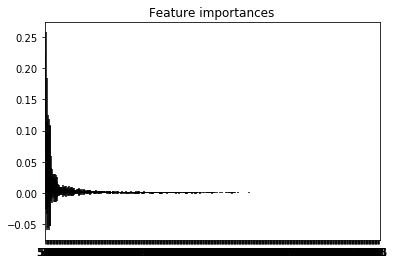

In [84]:
importances = model_rf_final.feature_importances_

# Compute standard deviations
std = np.std([tree.feature_importances_ for tree in model_rf_final.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(XtrainAndVal.shape[1]):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(XtrainAndVal.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(XtrainAndVal.shape[1]), indices)
plt.xlim([-1, XtrainAndVal.shape[1]])
plt.show()

In [ ]:
indices

To find the number of attributes to keep we will use the Elbow Method (for simplicity, we ignore the standard deviations). Is it possible to set the number of attributes as an hyper-parameter?

We should keep 29 attributes


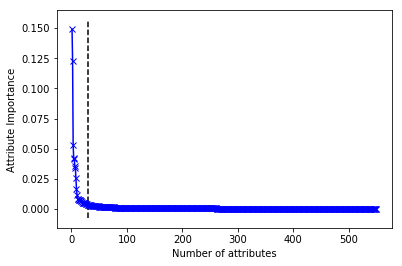

In [40]:
y = importances[indices]
x = range(1, len(y) + 1)
kn = KneeLocator(x, y, curve = 'convex', direction = 'decreasing')

plt.xlabel('Number of attributes')
plt.ylabel('Attribute Importance')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print("We should keep %d attributes" % kn.knee)

Select only the first 29 attributes

In [54]:
Xava_rf = Xava[:,indices]
Xava_rf = Xava_rf[:, 0:28]

Xtest_rf = Xtest[:,indices]
Xtest_rf = Xtest_rf[:,0:28]

XtrainAndVal_rf = XtrainAndVal[:, indices]
XtrainAndVal_rf = XtrainAndVal_rf[:, 0:28]

In [58]:
# Hyper-parameter tuning --> Bayesian Optimization
np.random.seed(0)

#In spite of the different hyper-parameters for a decision tree (max_depth, min_samples_split, max_features, min_samples_leaf),
#only max_depth and min_samples_split are used because of the academic goal of this study
param_tree_bayes_grid = {'max_depth': (2,30),
                         'min_samples_split': (2,100)
}
budget = 100
method_tree_bayes_att = BayesSearchCV(
        method_tree, 
        param_tree_bayes_grid, 
        scoring='neg_mean_absolute_error',
        refit = False,
        cv = partitions, 
        n_jobs =1, 
        verbose = 0,
        n_iter = budget
)

model_tree_bayes_att = method_tree_bayes_att.fit(Xava_rf, yava)
print("Best Bayes search max_depth, min_samples_split: {} \
and MAE for best Decision tree: {}".format(model_tree_bayes_att.best_params_, -model_tree_bayes_att.best_score_))

tree_final_att = tree.DecisionTreeRegressor()
tree_final_att.set_params(**model_tree_bayes_att.best_params_)
model_tree_final_att = tree_final_att.fit(XtrainAndVal_rf, ytrainAndVal)
model_tree_final_att_test_pred = model_tree_final_att.predict(Xtest_rf)
print("MAE for Decision Tree final is {}".format(mae(model_tree_final_att_test_pred, ytest)))


Best Bayes search max_depth, min_samples_split: {'max_depth': 29, 'min_samples_split': 76} and MAE for best Decision tree: 306.2005894012507
MAE for Decision Tree final is 316.32129495737126


The performance is similar (316.3213 vs 310.9637) and we are using 5% of the attributes!